# Filtering trajectories of moving objects disturbed by random acceleration


18.12.2019, Skoltech

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image
from numba import njit
import time
import cupy as cp

In [19]:
generate_report = False
def plot(trace_num, x_data, y_data, xlable = 'xlable', ylable = 'ylable',
                legend = 'legend', title = 'title', mode='lines'):
    plot.counter += 1
    fig_name = 'images/' + str(plot.counter) + '.jpg'
    fig = go.Figure()
    for i in range(trace_num):
        fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode=mode, name=legend[i], showlegend = True))
    fig.update_layout(
        title=go.layout.Title(
            text=title,
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text=xlable
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=ylable
            )
        )
    )
    if generate_report is True:
        fig.write_image(fig_name)
        display(Image(fig_name))
    else:
        fig.show()
plot.counter = 0

In [73]:
def motion_trajectory(x ,size, T, sigma_a, X_init=0, V_init=0):
    xp = cp.get_array_module(x)
    "Function for generating motion trajectory with normally distributed random acceleration"
    out = xp.zeros(size)
    V = xp.zeros(size)
    out[:,0] = X_init
    V[:,0] = V_init
    a = xp.random.normal(loc=0, scale=sigma_a, size=size)
    for i in range(1, size[1]):
        V[:,i] = V[:,i-1] + a[:,i-1]*T
        out[:,i] = out[:,i-1] + V[:,i-1]*T + (a[:,i-1]*T**2)/2
    return out

In [74]:
def measured_trajectory(data, sigma):
    xp = cp.get_array_module(data)
    "Supplementary function for generating measured trajectory"
    return xp.add(data, xp.random.normal(loc=0, scale=sigma, size=(data.shape[0], data.shape[1])))

**Generating a true trajectory 𝑋𝑖 and its measurements of an object motion disturbed by normally distributed random acceleration with given parameters**

In [152]:
N = 100000
M = 100000
X_init = 5
V_init = 1
T = 1
sigma_a = 0.2
sigma_n = 200

**Generating trajectories**

In [76]:
orig_time = %timeit -r 1 -o motion_trajectory(np.array([1]), (N,M), T, sigma_a, X_init=X_init, V_init=V_init)

792 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [151]:
x = cp.zeros(shape=(N,N))
x = motion_trajectory(x, (N,M), T, sigma_a, X_init=X_init, V_init=V_init)
orig_time_jit = %timeit -r 1  -o motion_trajectory(x, (N,M), T, sigma_a, X_init=X_init, V_init=V_init)

OutOfMemoryError: out of memory to allocate 800000000 bytes (total 4000000000 bytes)

**Generating measurements**

In [79]:
z = measured_trajectory(x, sigma_n)

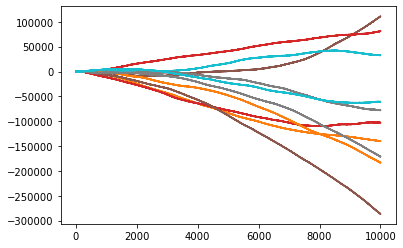

In [93]:
num_points = np.linspace(1,N,N)
for i in range(10):
    plt.plot(cp.asnumpy(x[i,:]))
    plt.plot(cp.asnumpy(z[i,:]))

In [81]:
plot(4, [num_points, num_points, num_points, num_points], [cp.asnumpy(x[0,:]), cp.asnumpy(z[0,:]),cp.asnumpy(x[1,:]), cp.asnumpy(z[1,:])], title='True trajectory and its measurements', xlable='steps', ylable='coordinate',
     legend=['real trajectory_0', 'measured trajectory_0','real trajectory_1', 'measured trajectory_1'])

In [138]:
def exp_smooth_forward(data, alpha, init=0):
    xp = cp.get_array_module(data)
    out = xp.empty((data.shape[0],data.shape[1]))
    out[:,0] = init
    for i in range(1, data.shape[1]):
        out[:,i] = out[:,i-1] + alpha*(data[:,i]-out[:,i-1])
    return out

In [139]:
def exp_smooth_backward(data, alpha, init=0):
    xp = cp.get_array_module(data)
    out = xp.empty((data.shape[0],data.shape[1]))
    out[:,-1] = init
    for i in reversed(range(data.shape[1]-1)):
        out[:,i] = out[:,i+1] + alpha*(data[:,i]-out[:,i+1])
    return out

In [140]:
def exp_smooth(data, alpha, init=0):
    return exp_smooth_backward(exp_smooth_forward(data, alpha, init), alpha, exp_smooth_forward(data, alpha, init)[:,-1])

In [141]:
def running_mean(data, M):
    out = pd.Series(data).rolling(window = M, center = True).mean()
    out[:int(M/2)+1] = out[int(M/2)]
    out[-int(M/2):] = out[data.size-int(M/2)-1]
    return out

In [142]:
exp_smoothed = exp_smooth(z,0.5)

In [143]:
plot(4, [num_points, num_points, num_points, num_points], [cp.asnumpy(z[0,:]), cp.asnumpy(z[1,:]), cp.asnumpy(exp_smoothed[0,:]), cp.asnumpy(exp_smoothed[1,:])], title='True trajectory and its measurements', xlable='steps', ylable='coordinate',
     legend=['real trajectory_0', 'measured trajectory_0','real trajectory_1', 'measured trajectory_1'])

GPU version

In [144]:
del exp_smoothed
orig_time = %timeit -r 1 -o exp_smooth(z,0.5)

2.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


CPU version

In [146]:
x = np.zeros(shape=(N,N))
x = motion_trajectory(x, (N,M), T, sigma_a, X_init=X_init, V_init=V_init)
z = measured_trajectory(x, sigma_n)

In [148]:
orig_time = %timeit -r 1 -o exp_smooth(z,0.5)

717 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [149]:
del x, z